# Finding Optimal Locations for  Hostel construction

In [825]:
from bs4 import BeautifulSoup as beautifulsoup
import requests
import pandas as pd
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
import numpy as np
import folium
import re
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import sklearn.utils
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Webscraping the NY community college data

In [3]:
url = 'https://www.communitycollegereview.com/college-size-stats/new-york#:~:text=The%20average%20community%20college%20in,Community%20College%20with%2026%2C606%20students.'

html_source = requests.get(url).text

In [13]:
soup = beautifulsoup(html_source,'lxml')

#Contains the entire table.
college_table = soup.find('div',id='school_list').ul

In [67]:
#Contains the column names of the table.
columns = college_table.find('li',class_='table_row_head')
columns

<li class="table_row_head">
<span class="table_cell_other_1">College</span>
<span class="table_cell_other_2"># Students</span>
<span class="table_cell_county" style="margin-right:0;">Location</span><div class="break"></div></li>

In [125]:
college = columns.findAll('span')[0].text
students = columns.findAll('span')[1].text
location = columns.findAll('span')[2].text

col = [college,students,location]

#We will use these as the dataframe column names.
print(college, stud, location)

College # Students Location


In [88]:
#Let's check how the data is nested for 1 row of the table. We will then loop over all rows using 'rows'
row = college_table.find('li',class_='table_row row_click')
row

<li class="table_row row_click"><div class="school-type-list-text"><span class="table_cell_other_1"><span class="rank"><span class="just-mobile-show-inline">Rank: #1</span><span class="just-desktop-show-inline">1.</span></span><div class="school_info"><a class="school_links" href="/cuny-borough-of-manhattan-community-college-profile"><span class="tooltip" schoolidid="818">CUNY Borough of Manhattan Community College</span></a><div class="thumbnail school-list-thumbnail"></div><span class="caption captionwidth"><strong>Public</strong></span><div class="compare_button"><label class="check-label"><input class="checkbox-input" id="compare_818" type="checkbox"/><label class="checkboxcss" for="compare_818"></label><span class="checkbox-label" for="compare_818"><span class="compare-btn">Add to Compare</span></span></label></div></div></span><span class="table_cell_other_2">26,606</span><span style="display: none;"><br/></span><span class="table_cell_county"><span style="float:none;">199 Chambe

In [176]:
rows = college_table.findAll('li',class_='table_row row_click')

college_name = []
no_of_students = []
location = []
for ro in rows:
    college_name.append(ro.find('div',class_='school_info').span.text)
    no_of_students.append(ro.find('span',class_='table_cell_other_2').text)
    location.append(ro.find('span',class_='table_cell_county').text.split('\n')[0] + ',' +ro.find('span',class_='table_cell_county').text.split('\n')[1].split(',')[0])
    #To select only the string needed from the 'table_cell_county' > span tag, a bit of list slicing had to be done.
    #Pardon the ugly code.
    #The below error can be ignored. We still get the required data.

AttributeError: 'NoneType' object has no attribute 'span'

##### The above error is unexpected, but the code works without any problems and we can get the desired dataframe.

In [187]:
cc_df = pd.DataFrame(zip(college_name,no_of_students,location),columns = col)
cc_df.to_excel('D:/DATA science/Coursera Data science/NY_colleges.xlsx',index = False)
cc_df

,College,# Students,Location
0,CUNY Borough of Manhattan Community College,"26,606","199 Chambers St,New York"
1,Suffolk County Community College,"26,600","533 College Rd,Selden"
2,Nassau Community College,"22,374","One Education Dr,Garden City"
3,CUNY LaGuardia Community College,"20,231","31-10 Thomson Ave,Long Island City"
4,CUNY Kingsborough Community College,"19,145","2001 Oriental Blvd,Brooklyn"
5,CUNY New York City College of Technology,"16,967","300 Jay St,Brooklyn"
6,CUNY Queensborough Community College,"16,182","222-05 56th Ave,Oakland Gardens"
7,Monroe Community College,"15,335","1000 E Henrietta Rd,Rochester"
8,SUNY Westchester Community College,"13,916","75 Grasslands Road,Valhalla"
9,Erie Community College,"12,733","121 Ellicott St,Buffalo"


## Data Exploration

A couple of addresses are wrong or mistyped, which need to be corrected.

In [227]:
#Renaming the address from the original 'one education Dr,Garden city' to '1 Education Dr,Garden City' so that geopy can find it.
cc_df.loc[2,'Location'] = '1 Education Dr,Garden City'

In [781]:
cc_df

,College,# Students,Location,Latitude,Longitude
0,CUNY Borough of Manhattan Community College,"26,606","199 Chambers St,New York",40.7172,-74.0122
1,Suffolk County Community College,"26,600","533 College Rd,Selden",40.8486,-73.059
2,Nassau Community College,"22,374","1 Education Dr,Garden City",40.0548,-86.943
3,CUNY LaGuardia Community College,"20,231","31-10 Thomson Ave,Long Island City",40.7464,-73.9426
4,CUNY Kingsborough Community College,"19,145","2001 Oriental Blvd,Brooklyn",40.5782,-73.935
5,CUNY New York City College of Technology,"16,967","300 Jay St,Brooklyn",40.6953,-73.9873
6,CUNY Queensborough Community College,"16,182","222-05 56th Ave,Oakland Gardens",40.756,-73.7565
7,Monroe Community College,"15,335","1000 E Henrietta Rd,Rochester",43.1158,-77.6165
8,SUNY Westchester Community College,"13,916","75 Grasslands Road,Valhalla",41.0687,-73.7907
9,Erie Community College,"12,733","121 Ellicott St,Buffalo",42.8818,-78.8726


# Location coordinates for the colleges

In [230]:
#Get the list of location to pass to geopy to get the coordinates.
location = list(cc_df['Location'])

['199 Chambers St,New York',
 '533 College Rd,Selden',
 '1 Education Dr,Garden City',
 '31-10 Thomson Ave,Long Island City',
 '2001 Oriental Blvd,Brooklyn',
 '300 Jay St,Brooklyn',
 '222-05 56th Ave,Oakland Gardens',
 '1000 E Henrietta Rd,Rochester',
 '75 Grasslands Road,Valhalla',
 '121 Ellicott St,Buffalo',
 '4585 West Seneca Turnpike,Syracuse',
 '80 Vandenburgh Ave,Troy',
 '2155 University Avenue,Bronx',
 '53 Pendell Rd,Poughkeepsie',
 '227 W 27th St,New York',
 '2350 Broadhollow Road,Farmingdale',
 '145 College Rd,Suffern',
 '1101 Sherman Dr,Utica',
 '500 Grand Concourse,Bronx',
 '907 Upper Front St,Binghamton',
 '3325 Marvin Sands Drive,Canandaigua',
 '115 South St,Middletown',
 '1650 Bedford Ave,Brooklyn',
 '2501 Jerome Avenue,Bronx',
 '78 Washington Avenue,Schenectady',
 '3111 Saunders Settlement Rd,Sanborn',
 '170 North St,Dryden',
 '525 Falconer St,Jamestown',
 '197 Franklin St,Auburn',
 '81 Willoughby Street,Brooklyn',
 '3 East 43 Street,New York',
 '1 Academic Dr,Corning',
 

In [251]:
Latitude = []
Longitude = []
for loc in location:
    geolocator = Nominatim(user_agent = 'foursquare')
    if geolocator.geocode(loc) is None:
        Latitude.append('NA')
        Longitude.append('NA')
    else:
        Latitude.append(geolocator.geocode(loc).latitude)
        Longitude.append(geolocator.geocode(loc).longitude)

In [278]:
# We can get the location coordinates of the 5 colleges through other methods.
# But or the sake of simplicity, let's drop all the NA values.

cc_df.drop([15,16,21,31,32], inplace = True)
print(cc_df.shape)
cc_df

(29, 5)


,College,# Students,Location,Latitude,Longitude
0,CUNY Borough of Manhattan Community College,"26,606","199 Chambers St,New York",40.7172,-74.0122
1,Suffolk County Community College,"26,600","533 College Rd,Selden",40.8486,-73.059
2,Nassau Community College,"22,374","1 Education Dr,Garden City",40.0548,-86.943
3,CUNY LaGuardia Community College,"20,231","31-10 Thomson Ave,Long Island City",40.7464,-73.9426
4,CUNY Kingsborough Community College,"19,145","2001 Oriental Blvd,Brooklyn",40.5782,-73.935
5,CUNY New York City College of Technology,"16,967","300 Jay St,Brooklyn",40.6953,-73.9873
6,CUNY Queensborough Community College,"16,182","222-05 56th Ave,Oakland Gardens",40.756,-73.7565
7,Monroe Community College,"15,335","1000 E Henrietta Rd,Rochester",43.1158,-77.6165
8,SUNY Westchester Community College,"13,916","75 Grasslands Road,Valhalla",41.0687,-73.7907
9,Erie Community College,"12,733","121 Ellicott St,Buffalo",42.8818,-78.8726


##### We are left with 29 community colleges in total.

In [728]:
ny_map = folium.Map(location = [40.7128, -74.0060],zoom_start = 6)

for lat,lng,col in zip(cc_df['Latitude'],cc_df['Longitude'],cc_df['College']):
    label = folium.Popup(col, parse_html = True)
    folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(ny_map)
        

ny_map

## Define foursquare Credentials

In [582]:
CLIENT_ID = 'K4LYUFZPJ30CIXXXXXCV5CFDAUWT0TS2U3G1ZV2TA15XXXXXX' # your Foursquare ID
CLIENT_SECRET = 'DFLWK3MJTXXXXXZDBPPPYSW544HGNGKRWOUQMD02UFXXXXXX' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30
radius = 200 #The radius should be less as it should be close to the hostel.

## Let's create a function to get all the nearby pubs

In [587]:
def getNearbyVenues(names, latitudes, longitudes, radius=200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['College', 
                  'College Latitude', 
                  'College Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [588]:
ny_venues = getNearbyVenues(names=cc_df['College'],
                            latitudes=cc_df['Latitude'],
                            longitudes=cc_df['Longitude']
                            )

CUNY Borough of Manhattan Community College
Suffolk County Community College
Nassau Community College
CUNY LaGuardia Community College
CUNY Kingsborough Community College
CUNY New York City College of Technology
CUNY Queensborough Community College
Monroe Community College
SUNY Westchester Community College
Erie Community College
Onondaga Community College
Hudson Valley Community College
CUNY Bronx Community College
Dutchess Community College
Fashion Institute of Technology
Mohawk Valley Community College
CUNY Hostos Community College
SUNY Broome Community College
Orange County Community College
CUNY Medgar Evers College
Monroe College
Schenectady County Community College
Niagara County Community College
Tompkins Cortland Community College
Jamestown Community College
Cayuga County Community College
ASA College
Adirondack Community College
SUNY College of Technology at Alfred


In [589]:
ny_venues

,College,College Latitude,College Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Washington Market Park,40.717046,-74.011095,Playground
1,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Whole Foods Market,40.715579,-74.011368,Grocery Store
2,CUNY Borough of Manhattan Community College,40.717249,-74.012180,SoulCycle TriBeCa,40.716178,-74.013007,Cycle Studio
3,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Tribeca Performing Arts Center,40.717594,-74.012198,Performing Arts Venue
4,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Polarn O. Pyret,40.716737,-74.011987,Kids Store
5,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Laughing Man Coffee & Tea,40.717394,-74.010103,Coffee Shop
6,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Tribeca Greenmarket,40.716802,-74.010880,Farmers Market
7,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Barnes & Noble,40.715605,-74.011786,Bookstore
8,CUNY Borough of Manhattan Community College,40.717249,-74.012180,Muse Paintbar,40.717701,-74.010549,Art Gallery
9,CUNY Borough of Manhattan Community College,40.717249,-74.012180,The Palm,40.716348,-74.012998,Steakhouse


In [634]:
# Inspect the variety of venue categories fetched by the api
venue_list = list(ny_venues['Venue Category'])


### Filtering the required venues

The Venue categories obtained, have a wide variety of categories including some like kids stores and office spaces, which would be reduntant for our analysis. 
Some of the hotspots that students hang out around would be bars,pubs,libraries,restaurants,cafes etc. We will only use these in our analysis.

In [604]:
# Search for bar, pub and other hotspots in venue category using regex.
v = 'Pub|Bar|Restaurant|Cafe|Pizza Place|Bookstore|Basketball Court|Supermarket|Wine|Coffee|Playground|Pool|Bistro|Gym|breakfast|Burger|Sandwich'


venues = ny_venues['Venue Category'].str.contains(v,regex = True)

In [605]:
ny_hotspots = ny_venues[venues]
ny_hotspots.shape

(83, 7)

In [606]:
ny_hotspots.head()

,College,College Latitude,College Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,CUNY Borough of Manhattan Community College,40.717249,-74.01218,Washington Market Park,40.717046,-74.011095,Playground
5,CUNY Borough of Manhattan Community College,40.717249,-74.01218,Laughing Man Coffee & Tea,40.717394,-74.010103,Coffee Shop
7,CUNY Borough of Manhattan Community College,40.717249,-74.01218,Barnes & Noble,40.715605,-74.011786,Bookstore
12,CUNY Borough of Manhattan Community College,40.717249,-74.01218,Gigino Trattoria,40.717300,-74.010688,Italian Restaurant
13,CUNY Borough of Manhattan Community College,40.717249,-74.01218,Hudson River Park Basketball Court,40.718763,-74.012985,Basketball Court


## Insights into the data

In [593]:
print('Total number of community colleges : {}'.format(len(cc_df['College'].unique())))
print('Number of colleges with trending venues around them : {}'.format(len(ny_venues['College'].unique())))

Total number of community colleges : 29
Number of colleges with trending venues around them : 26


In [613]:
ny_hotspots['Venue Category'].value_counts()[0:10]

Coffee Shop             13
Pizza Place              7
Sandwich Place           5
Chinese Restaurant       4
Gym                      4
Fast Food Restaurant     4
Bookstore                3
Burger Joint             3
Bar                      3
Italian Restaurant       3
Name: Venue Category, dtype: int64

The most popular hotspots are Coffee shops and Pizza places. Gyms are the only non-eatery place that have made to the top 5 hotspots

In [615]:
ny_hotspots['College'].value_counts()[0:6]

ASA College                                    12
CUNY LaGuardia Community College               10
Fashion Institute of Technology                 9
CUNY Hostos Community College                   8
Monroe College                                  7
CUNY Borough of Manhattan Community College     6
Name: College, dtype: int64

List of colleges with most trending places in their vicinity. These colleges' neighborhoods could potentially make for a great place for a student hostel since it has all the amenties around and is also less than 200 meters from the college. But we will also have to take into account the number of students enrolled in each college.

## Analyzing each college

We can one hot encode the categories and analyze the colleges and their vicinities further.

In [623]:
ny_onehot = pd.get_dummies(ny_hotspots[['Venue Category']], prefix="", prefix_sep="")

#Adding back the college names
ny_onehot['College'] = ny_hotspots['College'] 

# move neighborhood column to the first column
fixed_columns = [ny_onehot.columns[-1]] + list(ny_onehot.columns[:-1])
ny_onehot = ny_onehot[fixed_columns]

ny_onehot.head()

,College,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,...,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop
0,CUNY Borough of Manhattan Community College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,CUNY Borough of Manhattan Community College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,CUNY Borough of Manhattan Community College,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12,CUNY Borough of Manhattan Community College,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,CUNY Borough of Manhattan Community College,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [662]:
#Let's group by the college name and obtain the average count.
ny_grouped = ny_onehot.groupby('College').mean().reset_index()

ny_grouped.head()

,College,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,...,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop
0,ASA College,0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,0.083333,...,0.0,0.000,0.083333,0.083333,0.000,0.0,0.0,0.083333,0.0,0.0
1,Adirondack Community College,1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
2,CUNY Borough of Manhattan Community College,0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,0.000000,...,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
3,CUNY Bronx Community College,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0
4,CUNY Hostos Community College,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.0,0.125,0.000000,0.000000,0.125,0.0,0.0,0.000000,0.0,0.0


In [637]:
len(ny_grouped['College'].unique())

21

In [663]:
#Merge the 2 dataframes to get the student count.
ny_grouped = pd.merge(ny_grouped,cc_df, on = 'College')

ny_grouped.head()

,College,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,...,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,# Students,Location,Latitude,Longitude
0,ASA College,0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,0.083333,...,0.000,0.0,0.0,0.083333,0.0,0.0,"4,624","81 Willoughby Street,Brooklyn",40.6924,-73.986
1,Adirondack Community College,1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000,0.0,0.0,0.000000,0.0,0.0,"4,247","640 Bay Rd,Queensbury",43.3529,-73.6534
2,CUNY Borough of Manhattan Community College,0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,0.000000,...,0.000,0.0,0.0,0.000000,0.0,0.0,"26,606","199 Chambers St,New York",40.7172,-74.0122
3,CUNY Bronx Community College,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000,0.0,0.0,0.000000,0.0,0.0,"11,506","2155 University Avenue,Bronx",40.8577,-73.9129
4,CUNY Hostos Community College,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.125,0.0,0.0,0.000000,0.0,0.0,"6,985","500 Grand Concourse,Bronx",40.8181,-73.9268


In [664]:
#drop the unwanted columns
ny_grouped = ny_grouped.drop(['Location'],axis = 1)

ny_grouped.head()

,College,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,...,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,# Students,Latitude,Longitude
0,ASA College,0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,0.083333,...,0.083333,0.000,0.0,0.0,0.083333,0.0,0.0,"4,624",40.6924,-73.986
1,Adirondack Community College,1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,"4,247",43.3529,-73.6534
2,CUNY Borough of Manhattan Community College,0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,0.000000,...,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,"26,606",40.7172,-74.0122
3,CUNY Bronx Community College,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,"11,506",40.8577,-73.9129
4,CUNY Hostos Community College,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.125,0.0,0.0,0.000000,0.0,0.0,"6,985",40.8181,-73.9268


In [665]:
# move # students column to the second column

number_of_students = ny_grouped['# Students']
ny_grouped.drop(['# Students'],axis = 1,inplace = True)

ny_grouped.insert(1,'No._of_students',number_of_students)

ny_grouped.head()

,College,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,...,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
0,ASA College,"4,624",0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,...,0.083333,0.083333,0.000,0.0,0.0,0.083333,0.0,0.0,40.6924,-73.986
1,Adirondack Community College,"4,247",1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,43.3529,-73.6534
2,CUNY Borough of Manhattan Community College,"26,606",0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,...,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.7172,-74.0122
3,CUNY Bronx Community College,"11,506",0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.8577,-73.9129
4,CUNY Hostos Community College,"6,985",0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.000000,0.125,0.0,0.0,0.000000,0.0,0.0,40.8181,-73.9268


In [689]:
# Removing the , in the # students column and converting it to float.
ny_grouped[['No._of_students']] = ny_grouped[['No._of_students']].replace(to_replace=',',value = '',regex = True)
ny_grouped.head()

ny_grouped['No._of_students'] = ny_grouped['No._of_students'].astype(str).astype(float)
ny_grouped['No._of_students'].dtype


dtype('float64')

# Predictive modelling - Clustering

##### Model 1 : Clustering based on Location, and Number of students enrolled.

In [718]:
sklearn.utils.check_random_state(1000)

clus_dataset = ny_grouped[['No._of_students','Latitude','Longitude']]
clus_dataset = StandardScaler().fit_transform(clus_dataset)

km = KMeans(n_clusters = 4).fit(clus_dataset)


In [796]:
km.inertia_

10.46228744188803

In [763]:
print(km.labels_)

ny_grouped1 = ny_grouped.copy()

ny_grouped1.insert(1,'Cluster label',km.labels_)

ny_grouped1.head()

[1 0 3 1 1 3 1 3 3 2 1 0 2 0 1 2 0 1 0 0 0]


,College,Cluster label,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,Coffee Shop,College Bookstore,College Gym,Cuban Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Gym Pool,Italian Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Mexican Restaurant,Paella Restaurant,Piano Bar,Pizza Place,Playground,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
0,ASA College,1,4624.0,0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,0.083333,0.000000,0.0,0.0,0.000,0.00,0.083333,0.0,0.166667,0.0,0.0,0.083333,0.083333,0.000,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.083333,0.083333,0.000,0.0,0.0,0.083333,0.0,0.0,40.6924,-73.986
1,Adirondack Community College,0,4247.0,1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,43.3529,-73.6534
2,CUNY Borough of Manhattan Community College,3,26606.0,0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.7172,-74.0122
3,CUNY Bronx Community College,1,11506.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.8577,-73.9129
4,CUNY Hostos Community College,1,6985.0,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.125,0.25,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.125,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.000000,0.000000,0.125,0.0,0.0,0.000000,0.0,0.0,40.8181,-73.9268


### Defining a function to plot the maps

This function can be used to plot the map to show the kmeans clusters

In [790]:
def plot_map(k,latitude,longitude,college,cluster_label):
    maps = folium.Map(location = [40.7128, -74.0060],zoom_start = 6)

    # set color scheme for the clusters
    x = np.arange(k)
    ys = [i + x + (i*x)**2 for i in range(k)]
    colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
    rainbow = [colors.rgb2hex(i) for i in colors_array]


    for lat,lng,col,cluster in zip(latitude,longitude,college,cluster_label):
        label = folium.Popup(col + ' Cluster ' + str(cluster), parse_html = True)
        folium.CircleMarker(
        [lat,lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(maps)
    
    return maps
    

In [791]:
plot_map(4,ny_grouped1['Latitude'],ny_grouped1['Longitude'],ny_grouped1['College'],ny_grouped1['Cluster label'])

#### Model 2: Kmeans using all the features

In [ ]:
clus_dataset_1 = ny_grouped.iloc[ :,3:44]
clus_dataset1 = StandardScaler().fit_transform(clus_dataset1)

### KMeans for different values of k

In [823]:
wcss = []
for k in range(1,10):
    km1 = KMeans(n_clusters = k,random_state = 0,init = 'k-means++',)
    km1.fit(clus_dataset1)
    wcss.append(km1.inertia_)
wcss

[860.9999999999998,
 752.6504177131542,
 643.5848679246365,
 562.1238981260898,
 482.5270861197,
 401.754733408781,
 357.83683007024393,
 298.1271829997829,
 257.49234118021013]

##### Elbow plot

Text(0.5, 1.0, 'ELBOW PLOT')

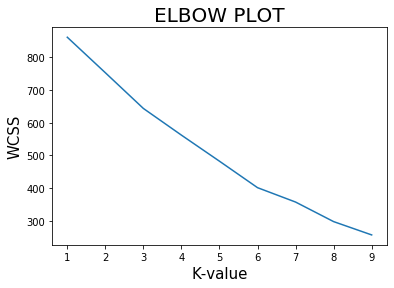

In [881]:
k = range(1,10)
plt.plot(k,wcss)
plt.xlabel('K-value',fontdict = {'fontsize' : 15})
plt.ylabel('WCSS',fontdict = {'fontsize' : 15})
plt.title('ELBOW PLOT', fontdict = {'fontsize' : 20})

This plot for the data that we have is really ambiguous. The elbow can be observed at 2 spots, 3 clusters and 6 clusters.
Let us build the model with 3 clusters.

In [832]:
km1 = KMeans(n_clusters = 3,random_state = 0).fit(clus_dataset1)


km1.labels_

array([2, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [833]:
plot_map(3,ny_grouped['Latitude'],ny_grouped['Longitude'],ny_grouped['College'],km1.labels_)

In [837]:
ny_grouped.insert(1,'Clusters',km1.labels_)

### Cluster 1

In [868]:
ny_grouped[ny_grouped['Clusters'] == 0].head().sort_values(by = ['No._of_students'], ascending = False)

,College,Clusters,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,Coffee Shop,College Bookstore,College Gym,Cuban Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Gym Pool,Italian Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Mexican Restaurant,Paella Restaurant,Piano Bar,Pizza Place,Playground,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
2,CUNY Borough of Manhattan Community College,0,26606.0,0.166667,0.0,0.0,0.166667,0.0,0.166667,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.166667,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.7172,-74.0122
5,CUNY LaGuardia Community College,0,20231.0,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.0,0.1,0.1,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.100000,0.0,0.0,0.0,0.1,0.00,0.0,0.10,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.1,0.0,0.0,0.1,40.7464,-73.9426
3,CUNY Bronx Community College,0,11506.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.8577,-73.9129
6,CUNY Medgar Evers College,0,6701.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.000000,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.6663,-73.9584
1,Adirondack Community College,0,4247.0,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.3529,-73.6534


In [865]:
## To obtain all the types of hotspots around colleges in Cluster 1
m1 = (ny_grouped[ny_grouped['Clusters'] == 0].iloc[ :,3:41] != 0).any()
a = m1.index[m1]
a

Index(['American Restaurant', 'Bar', 'Basketball Court', 'Bistro', 'Bookstore',
       'Boxing Gym', 'Burger Joint', 'Chinese Restaurant', 'Coffee Shop',
       'College Bookstore', 'College Gym', 'Fast Food Restaurant',
       'French Restaurant', 'Greek Restaurant', 'Gym', 'Gym / Fitness Center',
       'Gym Pool', 'Italian Restaurant', 'Juice Bar', 'Mexican Restaurant',
       'Paella Restaurant', 'Piano Bar', 'Pizza Place', 'Playground', 'Pool',
       'Sandwich Place', 'Spanish Restaurant', 'Supermarket',
       'Thai Restaurant', 'Wine Shop'],
      dtype='object')

### The colleges in cluster 1 are surrounded by a wide variety of hotspots. These college neighborhoods have a lot of amenties around them and it would be a safe bet to open a student hostel around any of these colleges.

The neighborhood around CUNY Borough of Manhattan Community College would be the best bet since it has a lot of students enrolled and also the neighborhood boasts of a wide variety of hotspots.


### Cluster 2

In [843]:
ny_grouped[ny_grouped['Clusters'] == 1]

,College,Clusters,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,Coffee Shop,College Bookstore,College Gym,Cuban Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Gym Pool,Italian Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Mexican Restaurant,Paella Restaurant,Piano Bar,Pizza Place,Playground,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
4,CUNY Hostos Community College,1,6985.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.125,0.0,0.0,0.0,0.0,0.0,40.8181,-73.9268


In [862]:
# To obtain all the types of hotspots around colleges in Cluster 2
m2 = (ny_grouped[ny_grouped['Clusters'] == 1][ny_grouped.iloc[ :,3:41] != 0]).any()
a = m2.index[m2]
a

Index(['Bar', 'Cuban Restaurant', 'Fast Food Restaurant', 'Karaoke Bar', 'Pub',
       'Southern / Soul Food Restaurant'],
      dtype='object')

### The colleges in cluster 2 are surrounded by hotspots like Bars and fast food restaurants

### Cluster 3

In [844]:
ny_grouped[ny_grouped['Clusters'] == 2]

,College,Clusters,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,Coffee Shop,College Bookstore,College Gym,Cuban Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Gym Pool,Italian Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Mexican Restaurant,Paella Restaurant,Piano Bar,Pizza Place,Playground,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
0,ASA College,2,4624.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.083333,0.083333,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.166667,0.0,0.0,0.083333,0.083333,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.083333,0.0,0.0,0.0,0.083333,0.0,0.0,40.6924,-73.986


In [866]:
# To obtain all the types of hotspots around colleges in Cluster 3
m3 = (ny_grouped[ny_grouped['Clusters'] == 2][ny_grouped.iloc[ :,3:41] != 0]).any()
a = m3.index[m3]
a

Index(['Asian Restaurant', 'Burger Joint', 'Chinese Restaurant',
       'French Restaurant', 'Gym', 'Italian Restaurant', 'Juice Bar',
       'Kebab Restaurant', 'Sandwich Place', 'Shanghai Restaurant',
       'Sushi Restaurant'],
      dtype='object')

### The colleges in cluster 3 are surrounded by hotspots like International cuisine restaurants.

#### Model 3 : DBSCAN

In [783]:
db = DBSCAN(eps = 0.40,min_samples = 4)

clus_data = ny_grouped[['Latitude','Longitude']]

db.fit(clus_data)

DBSCAN(algorithm='auto', eps=0.4, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=4, n_jobs=None, p=None)

In [782]:
#ny_grouped.drop(['dbscan_cluster_label'],axis = 1,inplace = True)

In [784]:
print(db.labels_)

ny_grouped.insert(2,'dbscan_cluster_label',db.labels_)
ny_grouped.head()

[ 0 -1  0  0  0  0  0  0  0 -1  0 -1 -1 -1  0 -1 -1 -1 -1 -1 -1]


,College,Cluster label,dbscan_cluster_label,No._of_students,American Restaurant,Asian Restaurant,Bar,Basketball Court,Bistro,Bookstore,Boxing Gym,Burger Joint,Chinese Restaurant,Coffee Shop,College Bookstore,College Gym,Cuban Restaurant,Fast Food Restaurant,French Restaurant,Greek Restaurant,Gym,Gym / Fitness Center,Gym Pool,Italian Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Mexican Restaurant,Paella Restaurant,Piano Bar,Pizza Place,Playground,Pool,Pub,Sandwich Place,Shanghai Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Thai Restaurant,Wine Shop,Latitude,Longitude
0,ASA College,1,0,4624.0,0.000000,0.083333,0.00,0.000000,0.0,0.000000,0.0,0.083333,0.083333,0.000000,0.0,0.0,0.000,0.00,0.083333,0.0,0.166667,0.0,0.0,0.083333,0.083333,0.000,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.083333,0.083333,0.000,0.0,0.0,0.083333,0.0,0.0,40.6924,-73.986
1,Adirondack Community College,3,-1,4247.0,1.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,43.3529,-73.6534
2,CUNY Borough of Manhattan Community College,5,0,26606.0,0.166667,0.000000,0.00,0.166667,0.0,0.166667,0.0,0.000000,0.000000,0.166667,0.0,0.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.166667,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.7172,-74.0122
3,CUNY Bronx Community College,1,0,11506.0,0.000000,0.000000,0.00,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,0.000,0.00,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000,0.000000,0.000000,0.000,0.0,0.0,0.000000,0.0,0.0,40.8577,-73.9129
4,CUNY Hostos Community College,1,0,6985.0,0.000000,0.000000,0.25,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.125,0.25,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.125,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.125,0.000000,0.000000,0.125,0.0,0.0,0.000000,0.0,0.0,40.8181,-73.9268


In [795]:
len(set(db.labels_))

2

In [785]:
m3 = folium.Map(location = [40.7128, -74.0060],zoom_start = 6)

# set color scheme for the clusters
x = np.arange(4)
ys = [i + x + (i*x)**2 for i in range(4)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


for lat,lng,col,cluster in zip(ny_grouped['Latitude'],ny_grouped['Longitude'],ny_grouped['College'],ny_grouped['dbscan_cluster_label']):
    label = folium.Popup(col + ' Cluster ' + str(cluster), parse_html = True)
    folium.CircleMarker(
    [lat,lng],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(m3)
    
m3  

### If the builder is looking at constructing just one student hostel in all of New York, then DBSCAN would be the better algorithm.

#### The algorithm shows a high denisty area in the Manhattan region. Based on this, a hostel around Central Park region would be extremely profitable to the builder. It would also benefit the the students since there is a high density of colleges in this vicinity.